In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from src.utils import metrics

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Ensures reproducibility for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

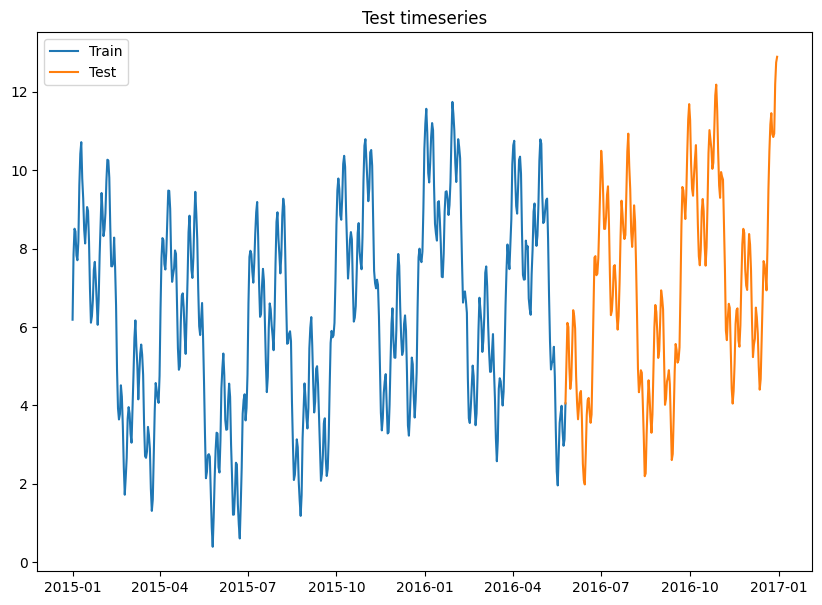

In [2]:
date = np.arange(datetime(2015, 1, 1), 
                 datetime(2016, 12, 31), 
                 timedelta(days=1)).astype(datetime)
days = date.shape[0]

noise = np.random.rand(days)*0.5 + 1

base = np.linspace(0, 2*np.pi, days) 
weekly = np.sin(base*days/7)
monthly = 2*np.sin(base*days/30)
seasonly = 2.5*np.sin(base*days/90) + 0.5
biyearly = np.cos(base*2)
ramp = np.linspace(3.5, 6, days)

values = biyearly + seasonly + monthly + weekly + noise + ramp

plt.figure(figsize=(10,7))
plt.plot(date[:int(days*0.7)+1], values[:int(days*0.7)+1], label = 'Train')
plt.plot(date[int(days*0.7):], values[int(days*0.7):], label = 'Test')
plt.legend()
plt.title('Test timeseries')
plt.show()

In [3]:
# ---------------------------
# Data Generation
# ---------------------------
date = np.arange(datetime(2015, 1, 1), 
                 datetime(2016, 12, 31), 
                 timedelta(days=1)).astype(datetime)
days = date.shape[0]

np.random.seed(42)
noise = np.random.rand(days) * 0.5 + 1

base = np.linspace(0, 2 * np.pi, days)
weekly = np.sin(base * days / 7)
monthly = 2 * np.sin(base * days / 30)
seasonly = 2.5 * np.sin(base * days / 90) + 0.5
biyearly = np.cos(base * 2)
ramp = np.linspace(3.5, 6, days)

values = biyearly + seasonly + monthly + weekly + noise + ramp

# ---------------------------
# Train/Validation/Test Split
# ---------------------------
# Test: last 30% of the days
test_split = int(days * 0.7)
y_train = values[:test_split]
y_test = values[test_split:]


In [4]:
print(y_train.shape, y_test.shape)

(510,) (220,)


Epoch 100/1000 - Train Loss: 0.3369 - Val Loss: 0.3089
Epoch 200/1000 - Train Loss: 0.2338 - Val Loss: 0.2081
Epoch 300/1000 - Train Loss: 0.1861 - Val Loss: 0.2249
Epoch 400/1000 - Train Loss: 0.1765 - Val Loss: 0.2316
Epoch 500/1000 - Train Loss: 0.1704 - Val Loss: 0.2209
Epoch 600/1000 - Train Loss: 0.1777 - Val Loss: 0.2518
Epoch 700/1000 - Train Loss: 0.1397 - Val Loss: 0.2039
Epoch 800/1000 - Train Loss: 0.1738 - Val Loss: 0.2634
Epoch 900/1000 - Train Loss: 0.1299 - Val Loss: 0.2127
Epoch 1000/1000 - Train Loss: 0.1667 - Val Loss: 0.2252

Best model found at epoch 925 with validation loss: 0.1844


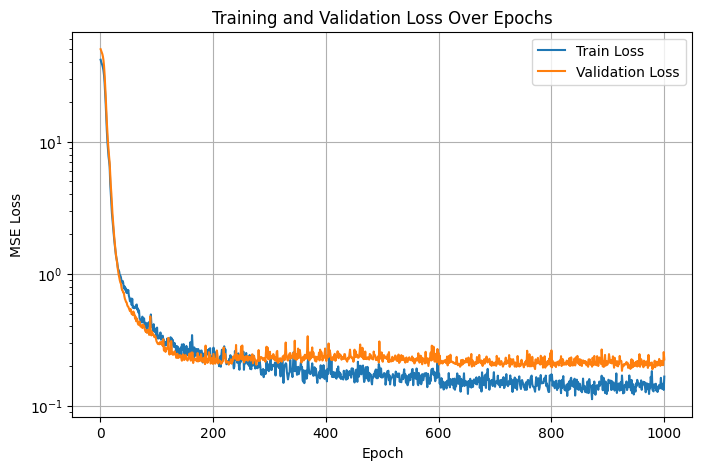

Metrics = {'MAE': 2.2241239921828946, 'MSE': 7.410050355941459, 'RMSE': 2.722140767106187, 'R2': -0.19866327406455442, 'MAPE': 38.01279255891162, 'sMAPE': 32.69131487233802}


In [5]:
# ---------------------------
# Data Generation
# ---------------------------
date = np.arange(datetime(2015, 1, 1), 
                 datetime(2016, 12, 31), 
                 timedelta(days=1)).astype(datetime)
days = date.shape[0]

np.random.seed(42)
noise = np.random.rand(days) * 0.5 + 1

base = np.linspace(0, 2 * np.pi, days)
weekly = np.sin(base * days / 7)
monthly = 2 * np.sin(base * days / 30)
seasonly = 2.5 * np.sin(base * days / 90) + 0.5
biyearly = np.cos(base * 2)
ramp = np.linspace(3.5, 6, days)

values = biyearly + seasonly + monthly + weekly + noise + ramp

# ---------------------------
# Train/Validation/Test Split
# ---------------------------
# Test: last 30% of the days
test_split = int(days * 0.7)
y_train = values[:test_split]
y_test = values[test_split:]

# Within the first 70%, use 80% for training and 20% for validation
val_split = int(len(y_train) * 0.8)
train_data = y_train[:val_split]
val_data = y_train[val_split:]

# ---------------------------
# Prepare PyTorch Dataset using a Sliding Window Approach
# ---------------------------
window_size = 30

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size]
        # Reshape x to (window_size, 1)
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)
        
train_dataset = TimeSeriesDataset(train_data, window_size)
val_dataset = TimeSeriesDataset(val_data, window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ---------------------------
# Define the LSTM Model
# ---------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size = 50, num_layers=1, dropout = 0.0, bidirectional = True):
        super(LSTMModel, self).__init__()

        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            dropout = dropout if num_layers > 1 else 0,
                            batch_first = True,
                            bidirectional = bidirectional)
        
        fnn_input_size = hidden_size * 2 if bidirectional else hidden_size 

        self.fc = nn.Linear(fnn_input_size, 1)
        
    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output at the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(hidden_size = 3, 
                  num_layers = 2,
                  dropout = 0.05, 
                  bidirectional = True
                  ).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-2, )
                       #weight_decay = 1e-4) # weight_decay adds L2 regularization

# ---------------------------
# Training Loop with Validation and Best Model Selection
# ---------------------------
epochs = 1_000
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

for epoch in range(epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x_batch.size(0)
        
    epoch_train_loss /= len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            epoch_val_loss += loss.item() * x_batch.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1  # Store the epoch (1-based index)
        
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

# Load the best model state for forecasting
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nBest model found at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

# ---------------------------
# Plot Training and Validation Loss Over Epochs
# ---------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Forecasting on Test Data (Recursive Multi-step Forecast)
# ---------------------------
model.eval()
y_pred = []
# Use the last window from the entire train+validation data as the starting point
last_window = y_train[-window_size:]
window = last_window.copy()

for i in range(len(y_test)):
    # Prepare input: shape (1, window_size, 1)
    input_seq = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        pred = model(input_seq).item()
    y_pred.append(pred)
    # Update the window: slide by one, adding the new prediction
    window = np.append(window[1:], pred)

errors = metrics.all_metrics(y_true = y_test, y_pred = y_pred)
print(f'Metrics = {errors}')

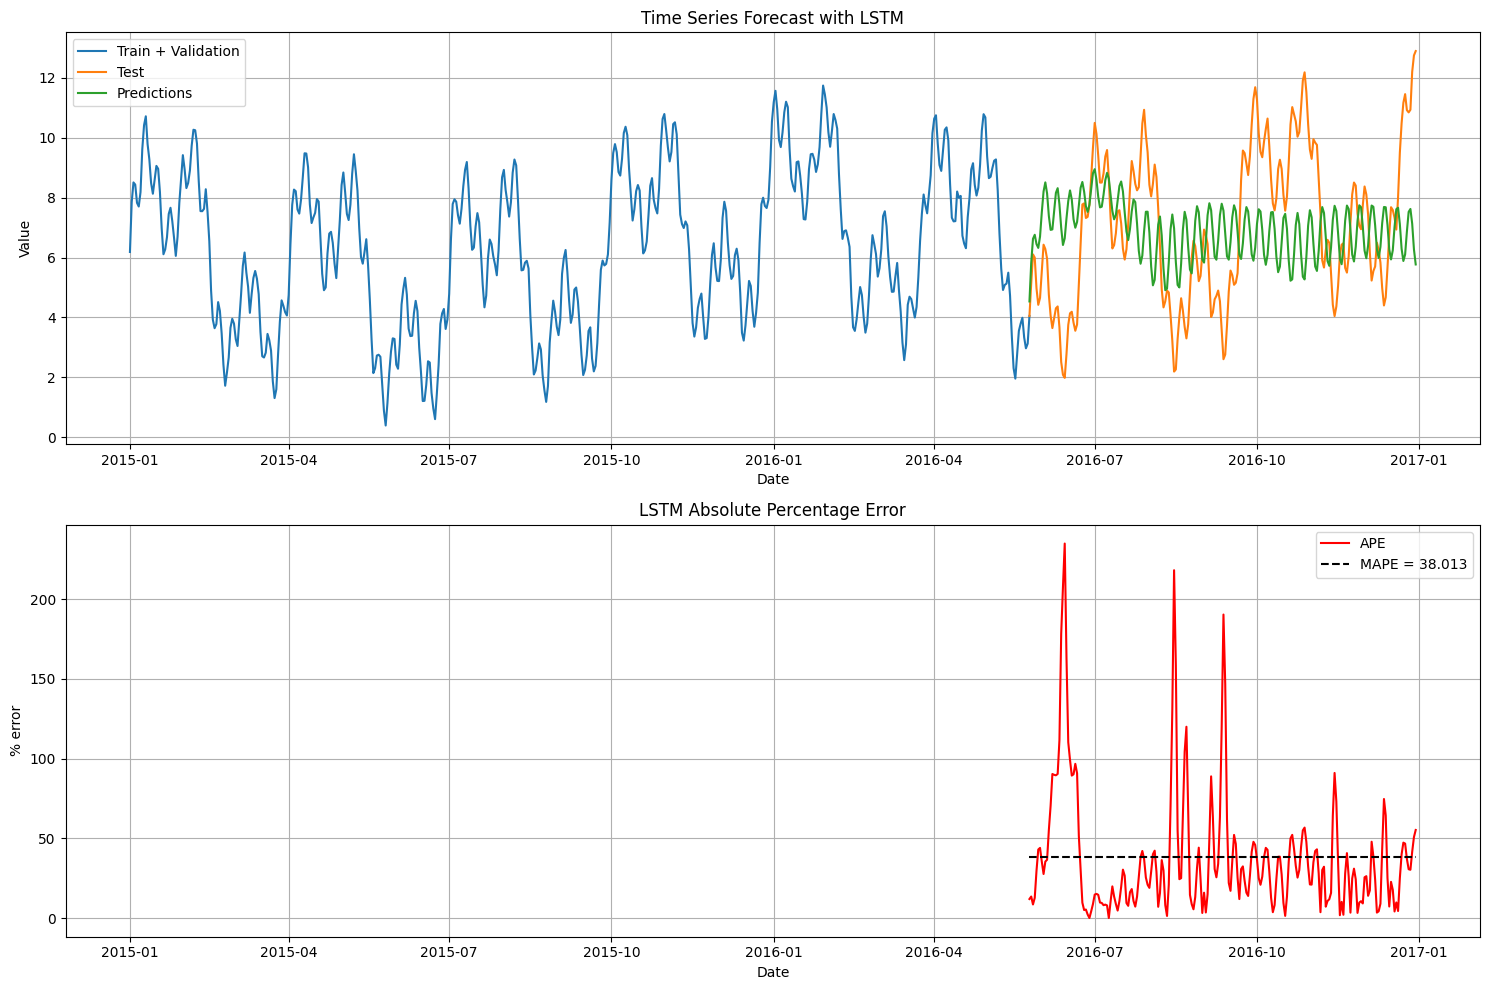

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# ---------------------------
# Plot the Forecast Results
# ---------------------------
ax[0].plot(date[:test_split+1], values[:test_split+1], label='Train + Validation')
ax[0].plot(date[test_split:], y_test, label='Test')
ax[0].plot(date[test_split:], y_pred, label='Predictions')
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Value")
ax[0].set_title("Time Series Forecast with LSTM")
ax[0].legend()
ax[0].grid()

# ---------------------------
# Plot the Forecast Error
# ---------------------------
ax[1].plot(date[test_split:], metrics.pe(np.asarray(y_test), np.asarray(y_pred)), label='APE', color = 'r')
ax[1].plot(date, values, alpha=0)
ax[1].plot(date[test_split:], errors['MAPE'] * np.ones(date[test_split:].shape[0]), linestyle='dashed', color='k', label=f'MAPE = {errors['MAPE'].round(3)}')
ax[1].set_xlabel("Date")
ax[1].set_ylabel("% error")
ax[1].set_title("LSTM Absolute Percentage Error")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()
